<a href="https://colab.research.google.com/github/leunseo/Deep_Learning_PROJECT/blob/main/Final_Project23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# importing Stopwords
import nltk
from nltk.corpus import stopwords
import string

# models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Sequential


# train test split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [5]:
#import data
mail = pd.read_csv("/content/df.csv", encoding="latin-1", usecols=["v1", "v2"])
mail = mail.copy()
mail.columns = ["label", "text"]
mail = mail[["text", "label"]]
mail["label"] = mail["label"].map({"ham": 0, "spam": 1}) #spam:1, ham:0
mail.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
#Checking for misssing values
mail.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
#Finding duplicate and Removing duplicate
mail.duplicated().sum() #403
mail = mail.drop_duplicates(keep='first')

#Result after removing duplicate
mail.duplicated().sum() #0

0

In [8]:
mail['label'].value_counts() #Number of spam: 653, Number of ham:4516

0    4516
1     653
Name: label, dtype: int64

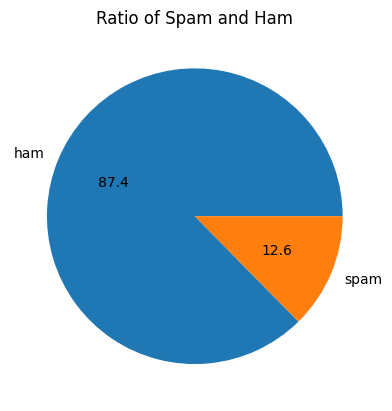

In [9]:
#Check data imbalances
from matplotlib import pyplot as plt

plt.pie(mail['label'].value_counts(), labels=['ham','spam'],autopct="%0.1f")
plt.title('Ratio of Spam and Ham')
plt.show()

In [10]:
mail['length'] = mail['text'].apply(len)
mail.head()

,text,label,length
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 1.0, 'Length of Text')

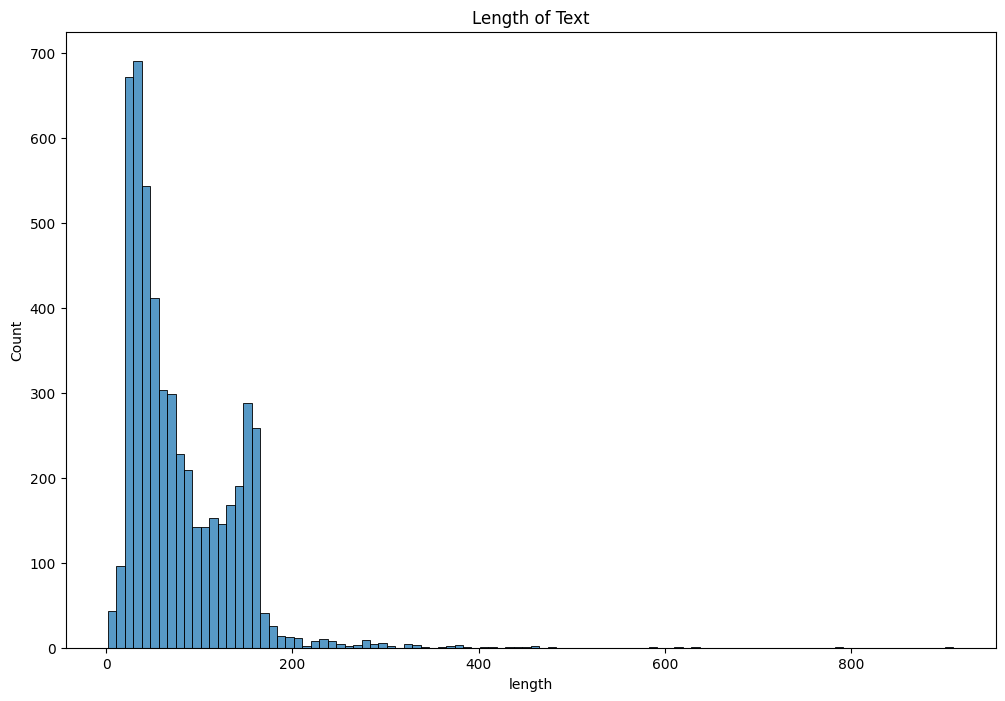

In [11]:
plt.figure(figsize=(12,8))
sns.histplot(x='length', data=mail, bins=100)
plt.title('Length of Text')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

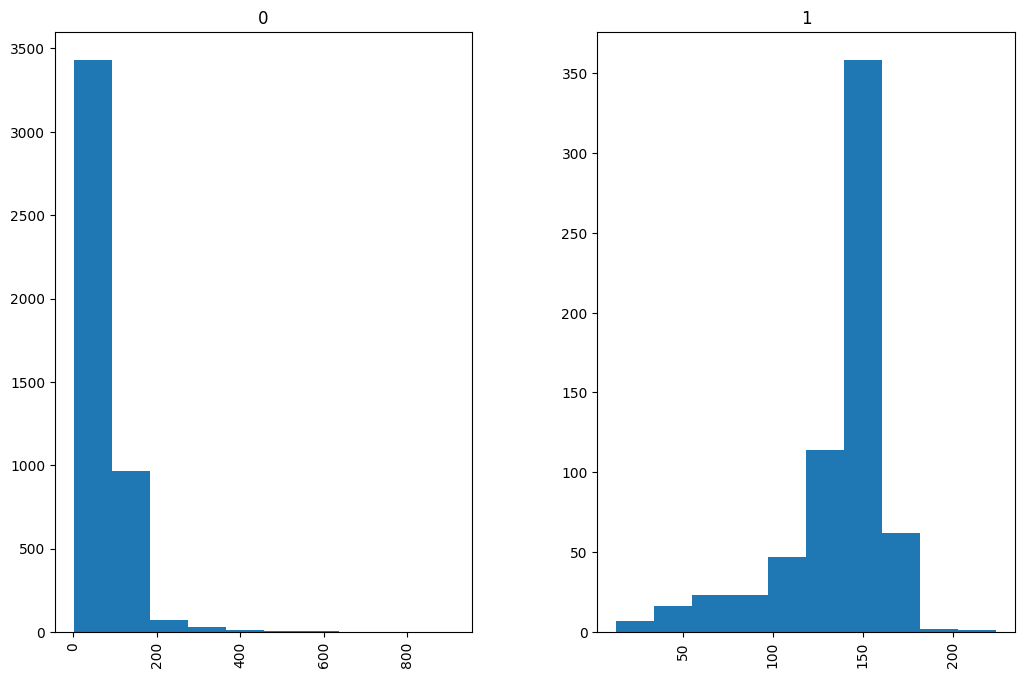

In [12]:
# distribution of spam and ham by length of text
mail.hist(column='length',by='label',figsize=(12,8))

In [13]:
# function to remove punctuation and stopwords
def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc=''.join(non_punc)
    return [word for word in non_punc.split() if word not in stopwords.words('english')]

In [14]:
# define X(features),y(target)
X= mail['text']
y=mail['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
import nltk

In [16]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
#Creating new Feature

#1. 'num_of_Character'
mail['num_of_character'] =mail['text'].apply(len)

#2. 'num of words'
mail['num_word'] = mail['text'].apply(lambda x:len(nltk.word_tokenize(x)))

#3. 'num_sentences'
mail['num_sentence'] = mail['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [18]:
mail[['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
#Analysis where label == 0 (ham)
mail[mail['label'] == 0][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [20]:
#Analysis where label == 1(spam)
mail[mail['label'] ==1][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


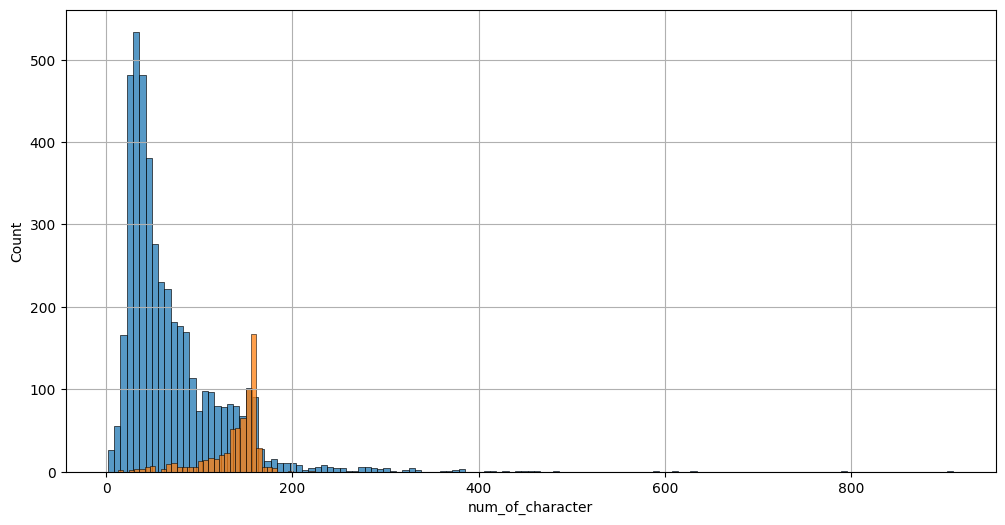

In [21]:
#Now see these conclusions by graphically
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(mail[mail['label'] == 0]['num_of_character'])
sns.histplot(mail[mail['label'] == 1]['num_of_character'])
plt.grid()

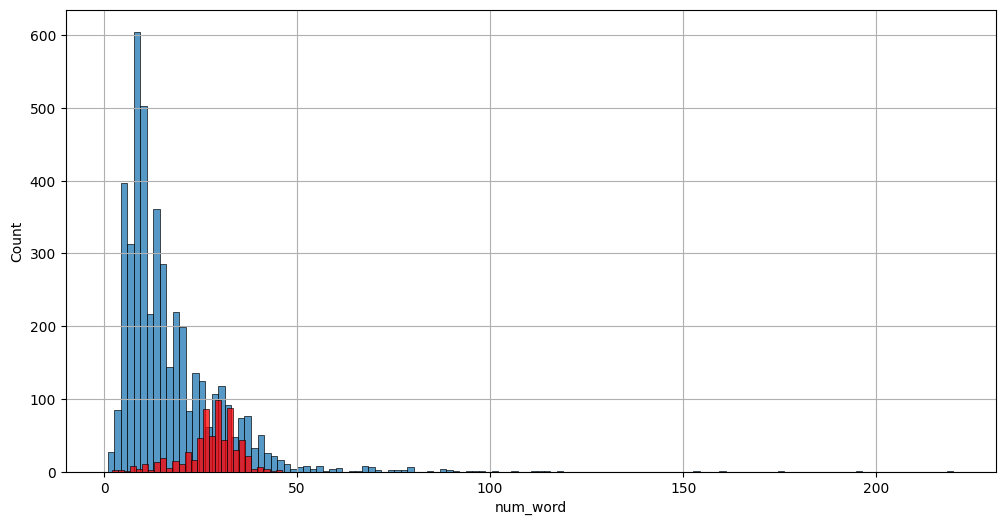

In [22]:
plt.figure(figsize=(12,6))
sns.histplot(mail[mail['label'] == 0]['num_word'])
sns.histplot(mail[mail['label'] == 1]['num_word'],color='red')
plt.grid()

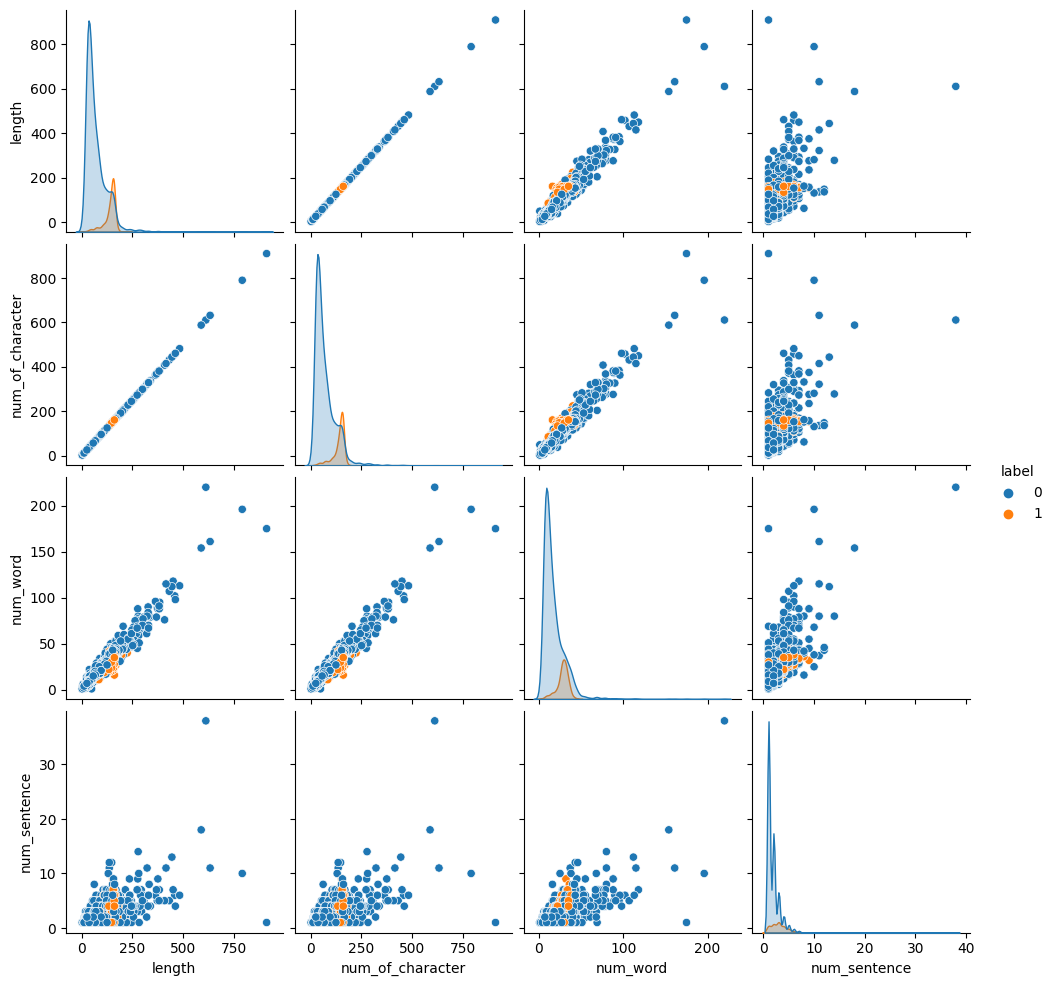

In [23]:
sns.pairplot(mail ,hue='label')
plt.grid()

<Axes: >

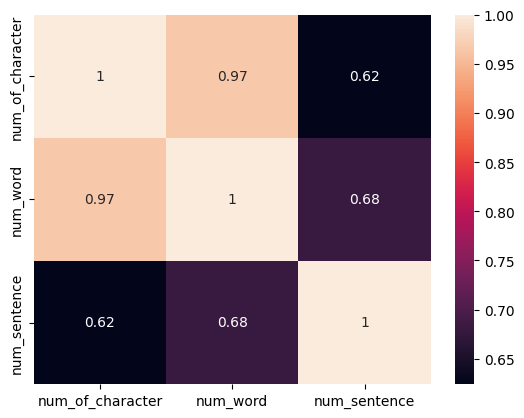

In [24]:
sns.heatmap(mail[['num_of_character','num_word','num_sentence']].corr(),annot=True)

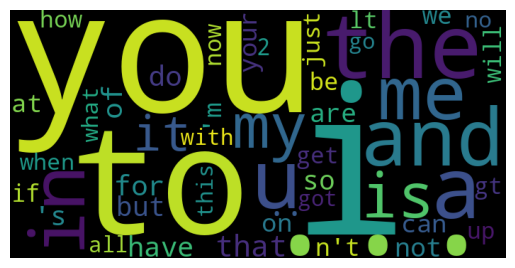

In [42]:
from wordcloud import WordCloud
print_wordcloud(ham_freq_top)

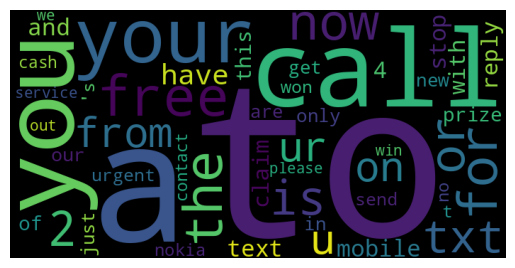

In [43]:
print_wordcloud(spam_freq_top)

In [25]:
#Data Preprocessing

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [26]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [52]:
mail['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [49]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [53]:
mail['transformed_text'] = mail['text'].apply(transform_text)

In [55]:
mail.head(3)

,text,label,length,num_of_character,num_word,num_sentence,transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,111,111,24,2,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,29,29,8,2,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...


In [34]:
#Define fuction 'Word Frenqeuncy'

def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

In [35]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

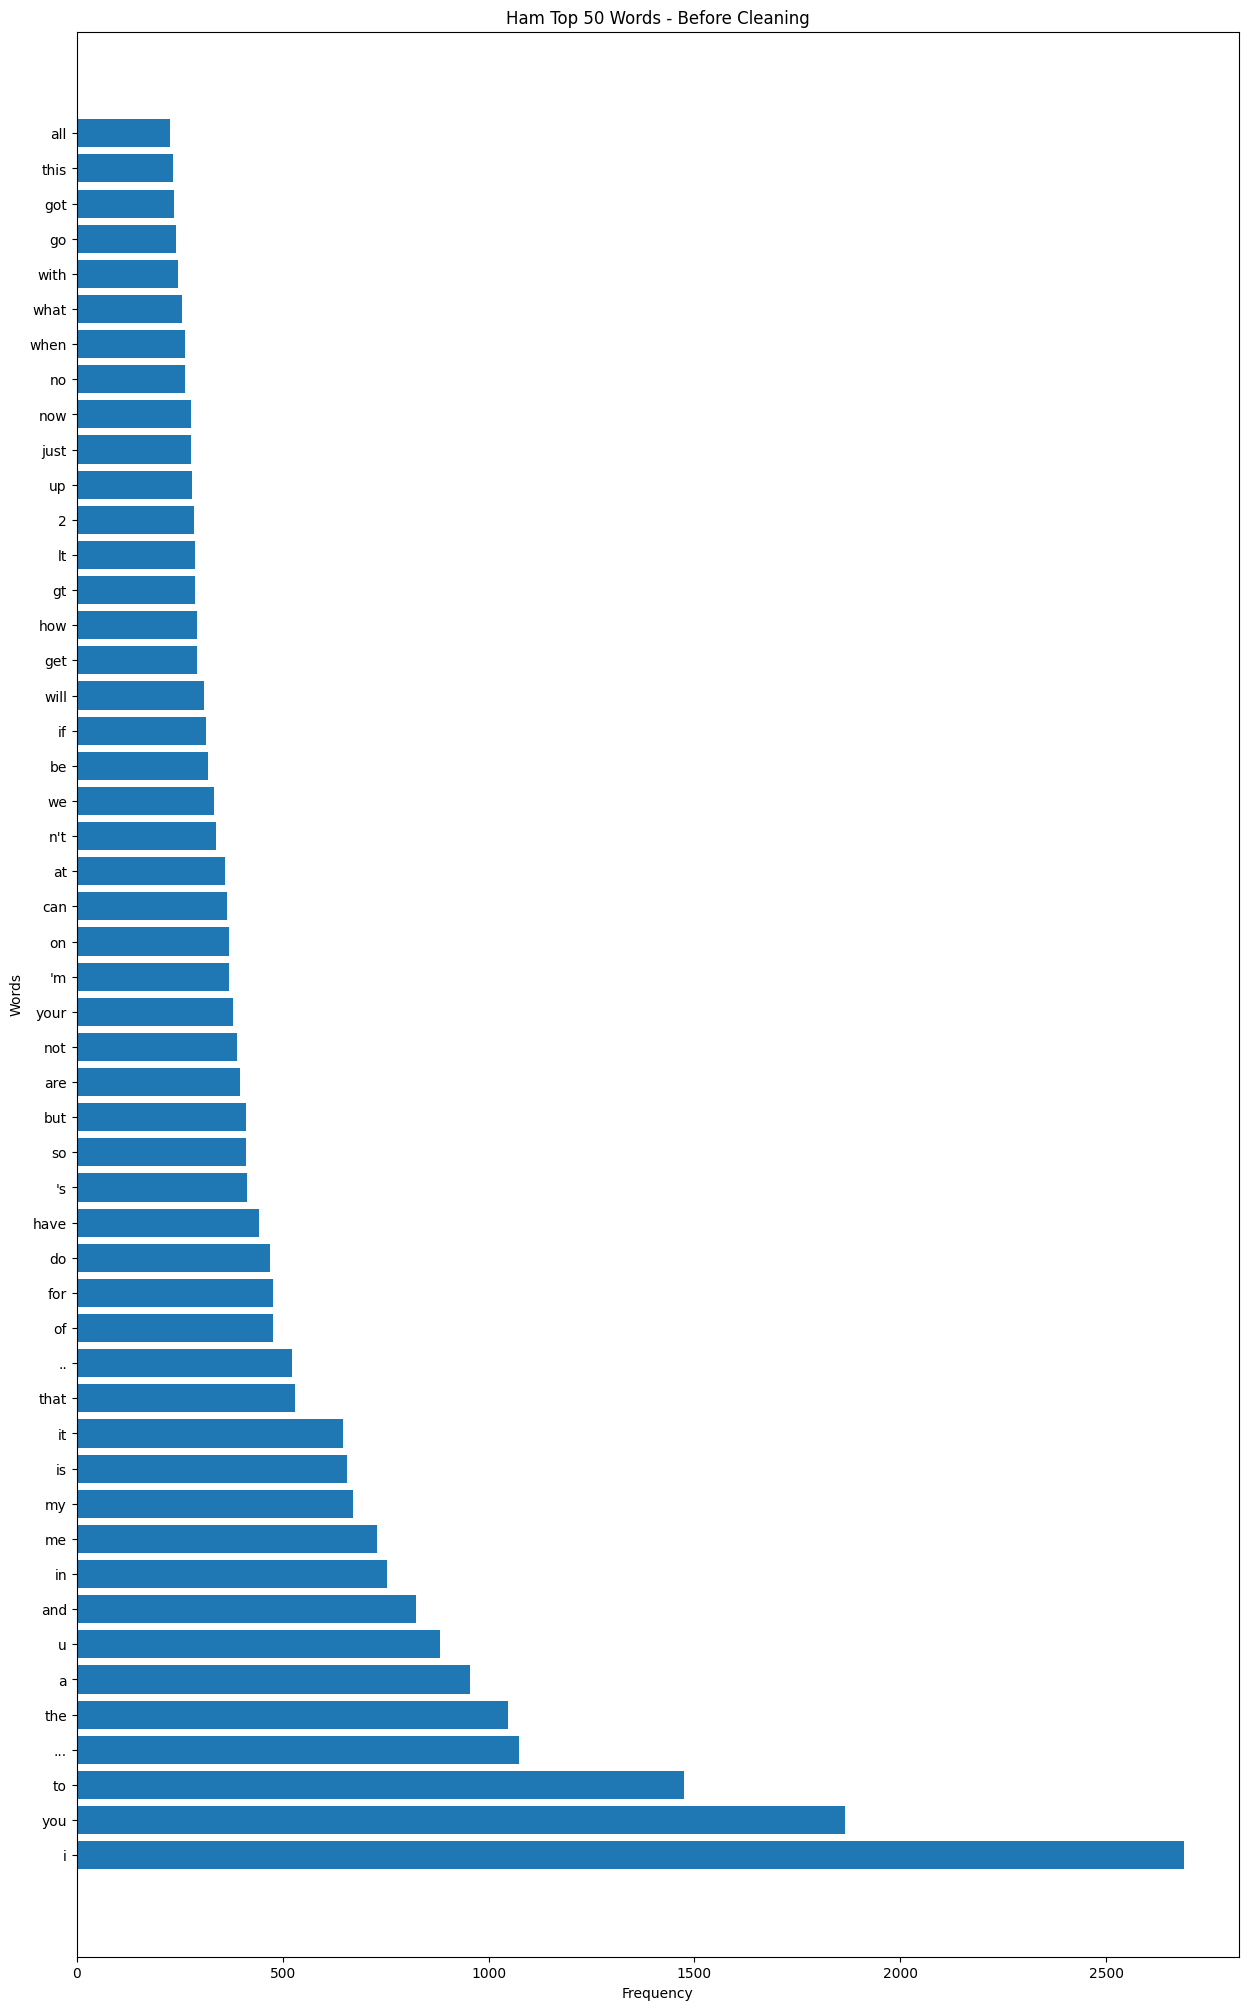

In [38]:
from collections import Counter
ham_freq_top = word_freq(mail, 0, "text", "Ham Top 50 Words - Before Cleaning")

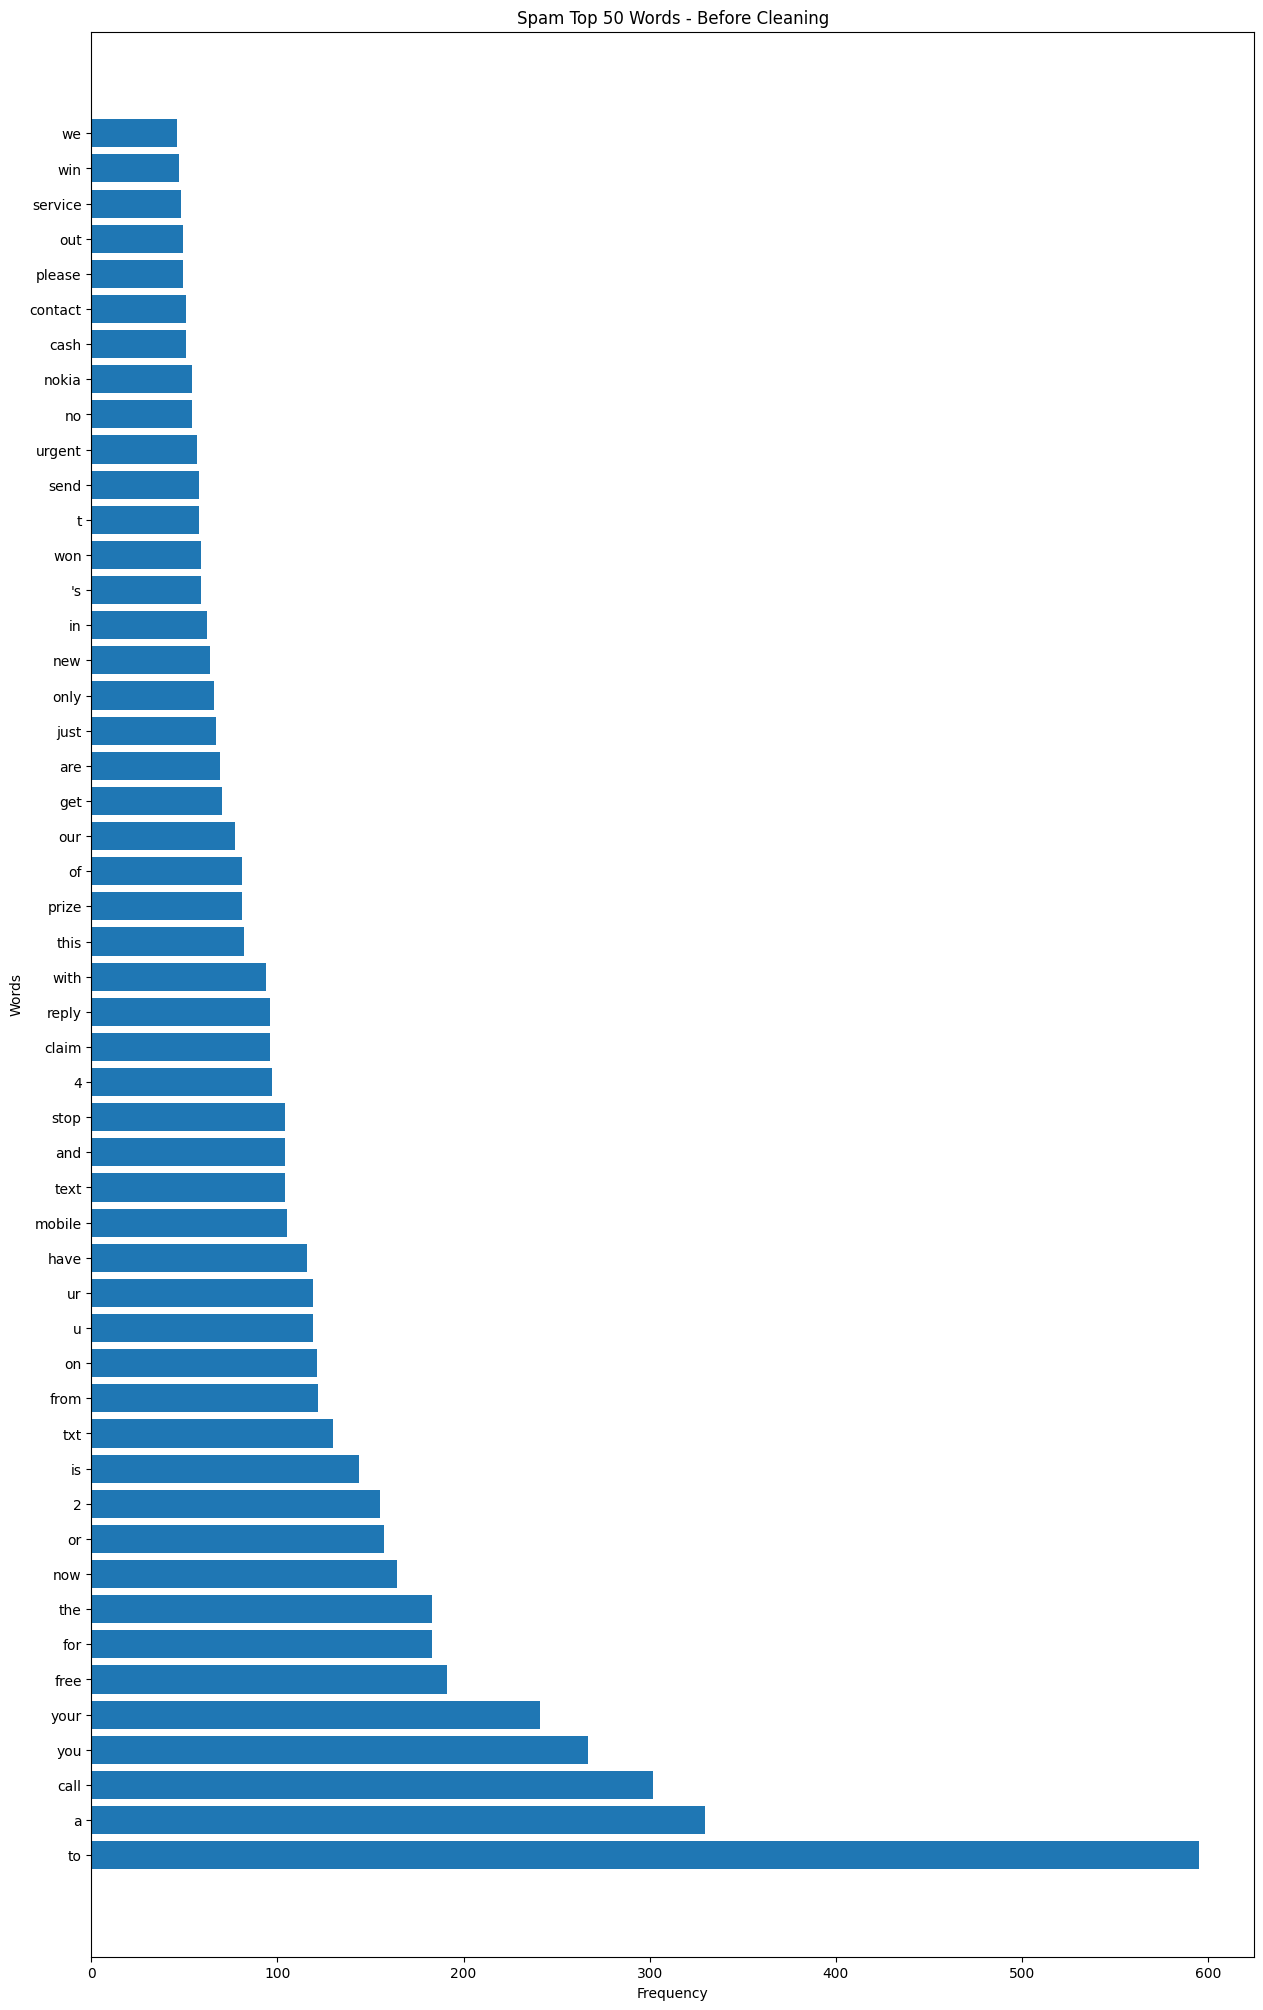

In [40]:
spam_freq_top = word_freq(mail, 1, "text", "Spam Top 50 Words - Before Cleaning")

In [59]:
stop_words = set(stopwords.words("english"))

In [60]:
smart_words = '/content/SmartStoplist.txt'

In [61]:
smart_stoplist = []

In [62]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [ ]:
smart_stoplist

In [ ]:
smart_stoplist.append("_")

In [ ]:
!ls -l /usr/share/nltk_data/

In [64]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [67]:
import re
from nltk.stem.wordnet import WordNetLemmatizer
mail["clean"] = mail["text"].apply(clean)

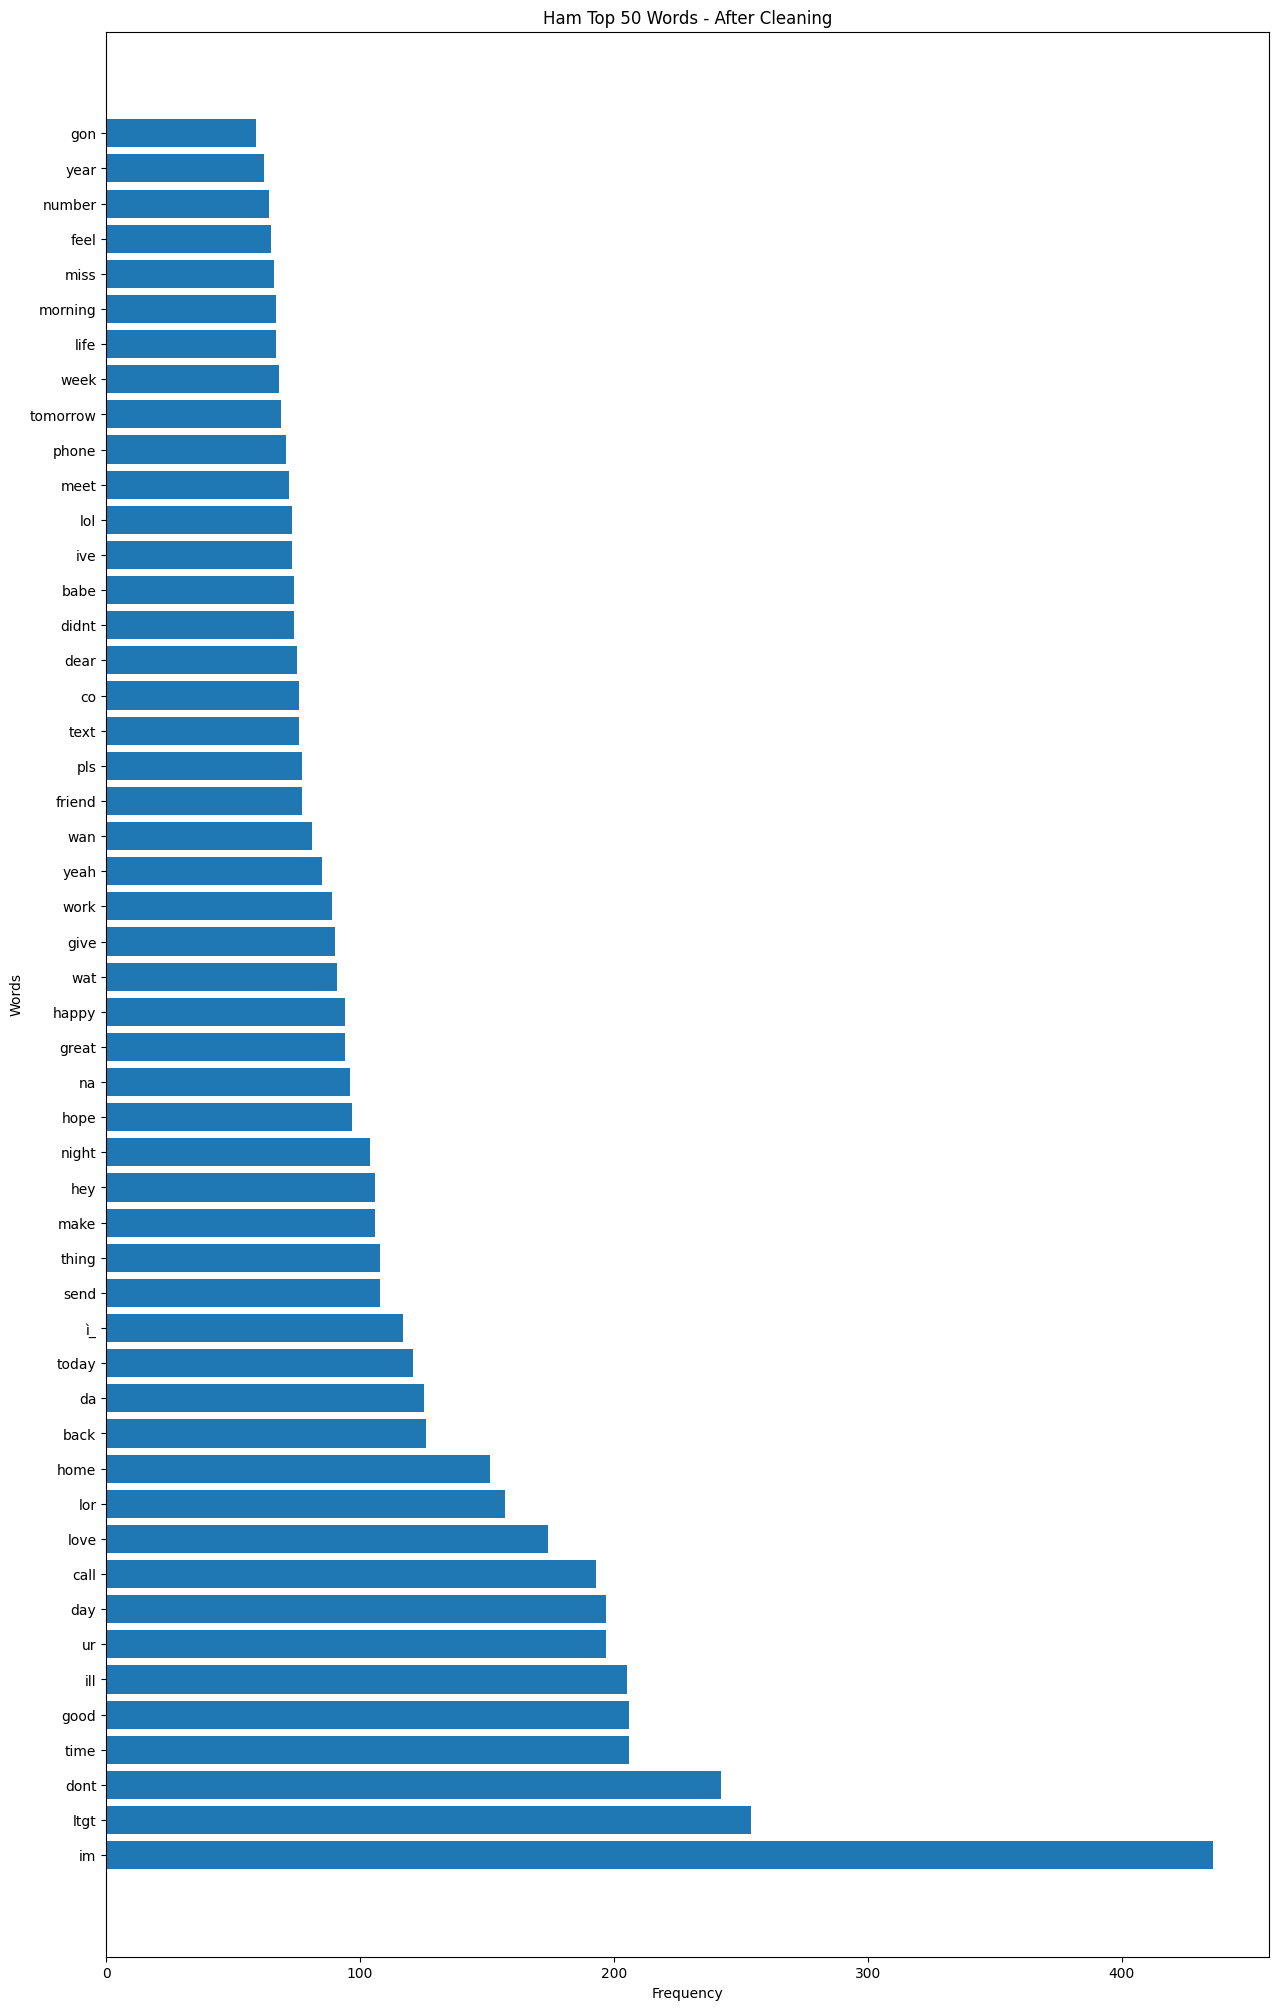

In [69]:
clean_ham_freq_top = word_freq(mail, 0, "clean", "Ham Top 50 Words - After Cleaning")

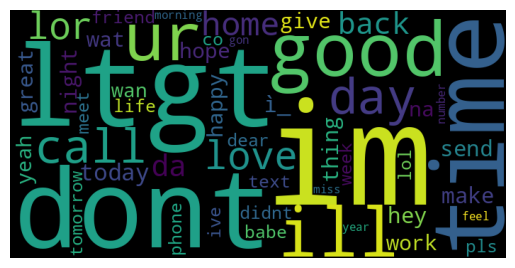

In [72]:
print_wordcloud(clean_ham_freq_top)

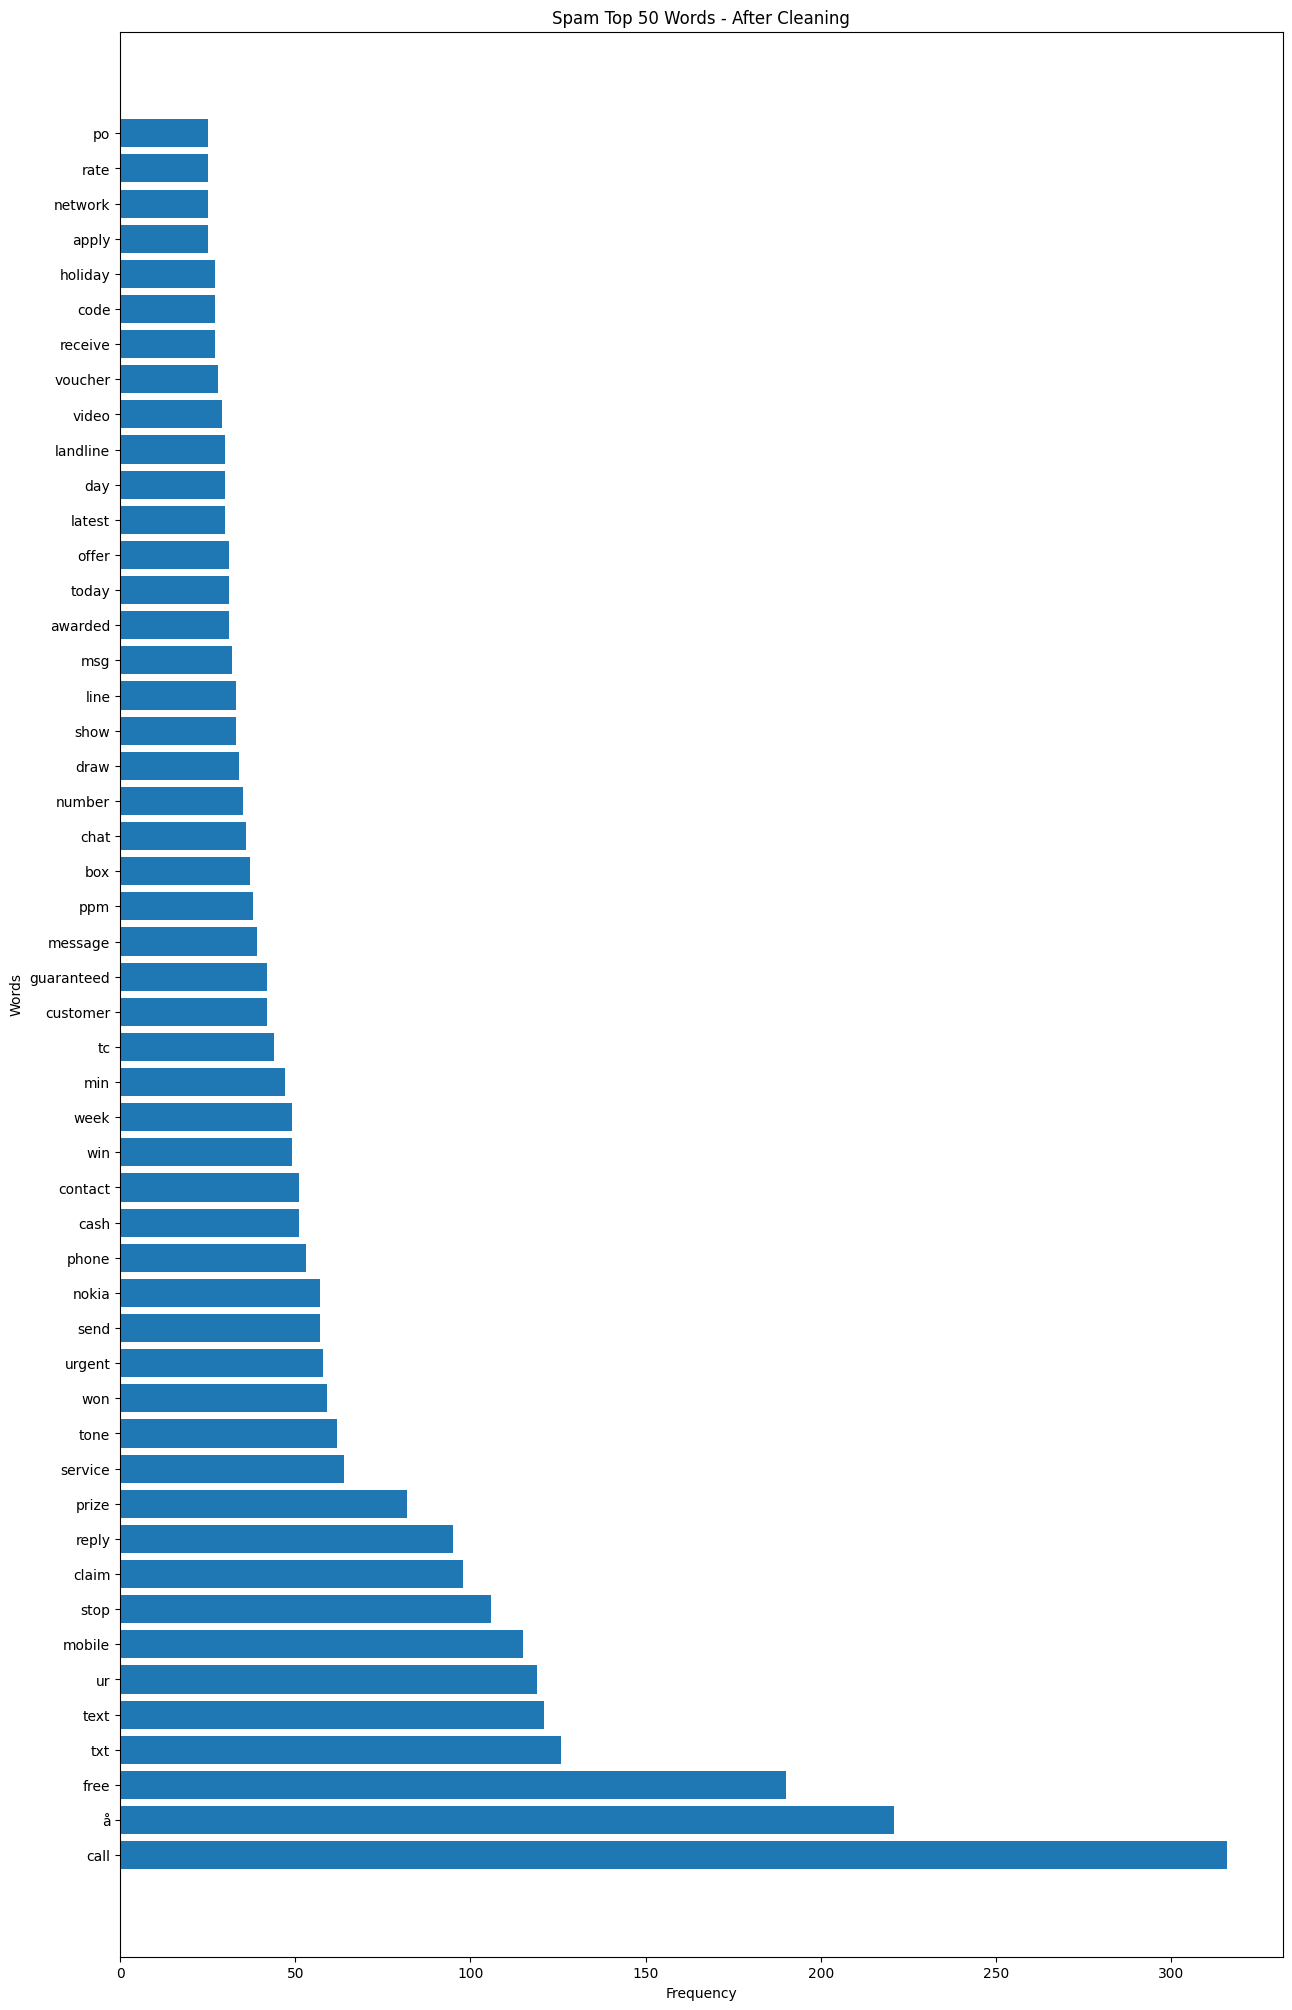

In [71]:
clean_spam_freq_top = word_freq(mail, 1, "clean", "Spam Top 50 Words - After Cleaning")

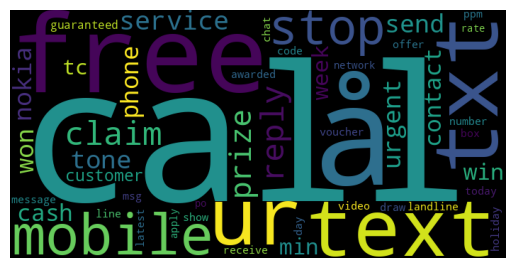

In [73]:
print_wordcloud(clean_spam_freq_top)

In [74]:
#Feature Scaling
X = mail["clean"]
y = mail["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

maxlen = 70

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [75]:
word_index = tokenizer.word_index
len(word_index)

7643

In [77]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [78]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [97]:
import tqdm

#ham_len = len(mail[mail["label"] == 0])
#spam_len = len(mail[mail["label"] == 1])
#values = np.array([total_0, total_1])

embeddings_index = {}
mail =  open("/content/df.csv", "r",  encoding="latin-1")
for line in tqdm.tqdm(mail):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([val for val in values[1:]])
    embeddings_index[word] = coefs

f.close()
print("Found %s word vectors." % len(embeddings_index))

SyntaxError: ignored